#VQ

In [ ]:
import tensorflow as tf
import numpy as np
class VectorQ(tf.keras.Model):
      def __init__(self, in_dim):
          super(VectorQ,self).__init__()


          dtype=tf.float32
          self.embeddin_dim= in_dim#from paper? #number of z's
          self.num_embedding= 4096 # the z's? no, dim of z I think its imporrtant
          self.commitment_cost= 1 #beta in eqn 4 from paper

          embedding_shape= [self.embeddin_dim, self.num_embedding]

          initer=tf.initializers.GlorotUniform()
          

          self.embeddings= tf.Variable(initer(embedding_shape, dtype), name="initilizer" ) #spelling

       
      def call(self, ins, is_training='False'):
              flatten_ins= tf.reshape(ins, [-1, self.embeddin_dim])
              
              #a notion of distance
              dist= tf.reduce_sum(flatten_ins**2, 1, keepdims=True)- 2*tf.matmul(flatten_ins, self.embeddings)+tf.reduce_sum(self.embeddings**2,0, keepdims=True)

              encoding_indices= tf.argmax(-dist,1)
              encodings= tf.one_hot(encoding_indices, self.num_embedding, dtype=dist.dtype)

              #potential crashing here based on embedding dim being equal to last dim of input i.e. the number of filters

              encoding_indices=tf.reshape( encoding_indices, tf.shape(ins)[:-1])
              
              quantized= self.quantize(encoding_indices)

              e_latent_loss= tf.reduce_mean((tf.stop_gradient(quantized)-ins)**2)
              q_latent_loss=tf.reduce_mean((quantized-tf.stop_gradient(ins))**2)
              loss= q_latent_loss+self.commitment_cost*e_latent_loss
              
              #loss*=10
              self.add_loss(loss)
              
              #striaght_through_est look it up

              quantized= ins+tf.stop_gradient(quantized-ins)
              # avg_probs= tf.reduce_mean(encodings,axis=0)
              # perplexity= tf.exp( -tf.reduce_sum(avg_probs*tf.math.log(avg_probs+1e-10))) #what

              return quantized

      def quantize(self,encoding_indices):
              w=tf.transpose(self.embeddings, [1,0])
              #w=self.embeddings
              return tf.nn.embedding_lookup(w,encoding_indices)

#VAE

In [ ]:
import tensorflow as tf
from tensorflow import Tensor, keras

ori_dim=28*28
inter_dim=1280
latent_dim=2
color_channels=3

SIZE=256

class downsample_residual(keras.layers.Layer):
      def __init__(self, downsample: bool, filters: int, kernel_size: int = 3):
            super(downsample_residual,self).__init__()
            self.downsample=downsample
            self.filters=filters
            self.kernel_size=kernel_size
            self.conv1=keras.layers.Conv2D(kernel_size=(kernel_size,kernel_size), strides= (1 if not downsample else 2), filters=filters, padding='same')
            self.conv2=keras.layers.Conv2D(kernel_size=2, strides= 2, filters=filters, padding='same')
            self.conv3=keras.layers.Conv2D(kernel_size=(kernel_size,kernel_size), strides= (1,1), filters=filters, padding='same')
            self.BN=keras.layers.BatchNormalization()
            self.BN1=keras.layers.BatchNormalization()
      @tf.function
      def call(self, x:Tensor):
          #https://github.com/lidless-vision/keras-residual-vae-tf2.3/blob/43b558f97b74d187ccb8811c3bc7f9e303f5f6c3/vae.py#L94 has batch norm and dropout
          y=self.conv1(x)
          #y=keras.layers.MaxPool2D(( 2,2) )(x)
          #y=keras.layers.Dropout(.4)(y)
          y=self.BN(y)
          #y= keras.layers.ReLU()(y)
          
          # #y=self.conv3(y)
          
          if self.downsample:
            x=self.conv2(x)
            x=self.BN1(x)
            #x=keras.layers.MaxPool2D(( 2,2) )(x)
          
          out=keras.layers.Add()([x,y])
          out=keras.layers.ReLU()(out)
          return out


class upsample_residual(keras.layers.Layer):
      def __init__(self, upsample: bool, filters: int, kernel_size: int = 3, in_shape:int =64, **kwargs):
            super(upsample_residual,self).__init__()
            self.upsample=upsample
            self.filters=filters
            self.kernel_size=kernel_size
            self.conv=keras.layers.Conv2D(filters=self.filters, 
                                        kernel_size=self.kernel_size, #kernels are important for transpose 
                                        strides=1,#(1 if not self.upsample else 2),
                                        padding='same')
            self.conv2=keras.layers.Conv2D(filters=(filters if self.upsample else in_shape),  #maintain dim when we add the idenity branch 
                                        kernel_size=self.kernel_size,
                                        strides= 1,
                                        padding='same')
            
            self.convT= keras.layers.Conv2D(filters=self.filters, 
                                        kernel_size=1, #1 or 2?
                                        strides= 1,
                                        padding='same')
            
            self.BN=keras.layers.BatchNormalization()
            self.BN1=keras.layers.BatchNormalization()
            self.BN2=keras.layers.BatchNormalization()
      @tf.function 
      def call(self,x):
          

          y=self.conv(x)
         
          
          
          # y=keras.layers.ReLU()(y)
         
          y=self.BN(y)
          # if self.upsample:
          #     y=keras.layers.UpSampling2D((2,2))(y)

          # y=self.conv2(y)
          
          # y=self.BN1(y)
          if self.upsample:
              y=keras.layers.UpSampling2D((2,2))(y)
          
          # #print(y.shape)
          if self.upsample:
              x=self.convT(x)
              x=self.BN2(x)
              x=keras.layers.UpSampling2D((2,2))(x)
              
          
              
          # #print(x.shape)
          out= keras.layers.Add()([x,y])


          out=keras.layers.ReLU()(out)
          
          #if gradient doesnt exist then Im missing the x path
          return out



input= tf.keras.Input(shape=(SIZE,SIZE,color_channels))
w=tf.keras.layers.Conv2D(64*color_channels, (3,3), activation='relu', padding='same')(input)
w=tf.keras.layers.MaxPooling2D((2,2), padding='same')(w)
w=tf.keras.layers.Conv2D(32*color_channels, (3,3), activation='relu', padding='same')(w)
w=tf.keras.layers.MaxPooling2D((2,2), padding='same')(w)
w=tf.keras.layers.Conv2D(32*color_channels, (3,3), activation='relu', padding='same')(w)
w=tf.keras.layers.MaxPooling2D((2,2), padding='same')(w)
w=tf.keras.layers.Conv2D(32*color_channels, (3,3), activation='relu', padding='same')(w)
w=tf.keras.layers.MaxPooling2D((2,2), padding='same')(w)
w=tf.keras.layers.Conv2D(32*color_channels, (3,3), activation='relu', padding='same')(w)
w=tf.keras.layers.MaxPooling2D((2,2), padding='same')(w)
filter=32*3
# # #!!!!!!!!!!!!!!!!!!
# # #need a lamda type layer not passing a tensor as input 
# w=downsample_residual( True, filter, 3)(input)

# for i in range(3):
  
#   w=downsample_residual( True, filter, 3)(w)
#   #w=downsample_residual( False, filter, 3)(w)
  
#   filter*=2

# # w=downsample_residual( True, 2, 3)(w)

# # for i in range(3):
# #   w=downsample_residual( False, 16, 3)(w)


print(w.shape)
#h=tf.keras.layers.Dense(inter_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-5))(w)
w=tf.keras.layers.Flatten()(w)
w=tf.keras.layers.Dense(128)(w)

z_mean=tf.keras.layers.Dense(latent_dim)(w)
z_log_sig=tf.keras.layers.Dense(latent_dim)(w)

# w=downsample_residual( True, 2, 3)(w)
# v=VectorQ()(w)
# encoder= tf.keras.Model(input, v, name='encoder')

(None, 8, 8, 96)


In [ ]:
from tensorflow.keras import backend as K

def sample(args):
    z_mean, z_log_sig = args
    epsilon= K.random_normal(shape= (K.shape(z_mean)[0], latent_dim),mean=0., stddev=.001) #stddev was .1
    #re-paramerterization
    return z_mean+K.exp(z_log_sig)*epsilon

z=tf.keras.layers.Lambda(sample)([z_mean,z_log_sig])

In [ ]:

from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
encoder= tf.keras.Model(input, [z_mean,z_log_sig,z], name='encoder')


print(encoder.summary())

v=VectorQ(2)

latent_in = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
x= v(latent_in)
x= tf.keras.layers.Dense(16)(x) #compatability hack, fix it
x=tf.keras.layers.Reshape(target_shape=(4,4,1))(x)

# x=tf.keras.layers.Conv2D(32*color_channels,(3,3), activation='relu', padding='same')(x)
# x=tf.keras.layers.UpSampling2D( (2,2))(x)
# x=tf.keras.layers.Conv2D(64*color_channels,(3,3), activation='relu', padding='same')(x)
# x=tf.keras.layers.UpSampling2D( (2,2))(x)
# x=tf.keras.layers.Conv2D(64*color_channels,(3,3), activation='relu', padding='same')(x)
# x=tf.keras.layers.UpSampling2D( (2,2) )(x)

# x=tf.keras.layers.Conv2D(16*color_channels,(3,3), activation='relu', padding='same')(x)
# x=tf.keras.layers.UpSampling2D( (2,2) )(x)
# x=tf.keras.layers.Conv2D(16*color_channels,(3,3), activation='relu', padding='same')(x)
# x=tf.keras.layers.UpSampling2D( (2,2) )(x)
# x=tf.keras.layers.Conv2D(16*color_channels,(3,3), activation='relu', padding='same')(x)
# x=tf.keras.layers.UpSampling2D( (2,2) )(x)

# x=tf.keras.layers.Conv2D(32*color_channels,(3,3), activation='relu', padding='same')(x)
# x=tf.keras.layers.UpSampling2D( (2,2) )(x)
# x=tf.keras.layers.Conv2D(32*color_channels,(3,3), activation='relu', padding='same')(x)
# x=tf.keras.layers.UpSampling2D( (2,2) )(x)

filters=128
# #x= upsample_residual( False, 2,3)(x)
# # for i in range(2):
# #   x=upsample_residual(False, 64, 3)(x)
for i in range(6): #this can cause oom if set too high

  x= upsample_residual( True, filters,7,x.shape[-1])(x) #kernel size makes a difference 
  #x=upsample_residual( False, filters,3,x.shape[-1])(x)
  
 
  if i%3==0:
    filters/=2
# v=VectorQ(in_dim=int(filters*2))
# x=v(x)
# for i in range(5):
#     x=upsample_residual( True, filters,3, x.shape[-1] )(x)
    
#     filters/=2
 
  












# x=tf.keras.layers.Conv2D(64*color_channels,(5,5), activation='relu')(x)
# x=tf.keras.layers.UpSampling2D( (2,2) )(x)


outs= tf.keras.layers.Conv2D( color_channels,(3,3), activation='sigmoid', padding='same')(x) #tf.keras.layers.Dense(ori_dim, activation='sigmoid')(x)

decoder=tf.keras.Model(latent_in, outs, name='decoder')
print(decoder.summary())
outputs= decoder(encoder(input)[2] )

# code=tf.keras.layers.Input(shape=(), dtype=tf.int32)
# sample_layer=v.quantize(code) #tf.keras.layers.Lambda(lambda d: v.quantize(d), name="sample_from_codebook")(code)
# print(sample_layer.shape)
# sample_out= decoder(sample_layer)
# sampler=tf.keras.Model(code, sample_out, name='sampler')
# print(sampler.summary())
vae=tf.keras.Model(input, outputs, name='vq_vae')
print(vae.summary())

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 192 5376        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 192 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 96) 165984      max_pooling2d[0][0]              
____________________________________________________________________________________________

In [ ]:
#need to relook at make sure its all correct 

recon_loss=tf.keras.losses.binary_crossentropy(input,outputs)
recon_loss= (1)*recon_loss #does order matter here?
#recon_loss= tf.reduce_sum(recon_loss, axis=[1,2])
print(recon_loss.shape)
# kl_loss= 1+z_log_sig-K.square(z_mean)- tf.exp(z_log_sig)
# print(kl_loss.shape)
# kl_loss= tf.reduce_sum(kl_loss,axis=None)

# kl_loss*=-0.5
vae_loss=tf.reduce_mean(recon_loss)

vae.add_loss(vae_loss)
opt=tf.keras.optimizers.Adam() #learning rate is important

vae.compile(optimizer=opt)
vae.summary()

(None, 256, 256)
Model: "vq_vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 1207556     input_1[0][0]                    
__________________________________________________________________________________________________
decoder (Functional)            (None, 256, 256, 3)  992147      encoder[0][2]                    
__________________________________________________________________________________________________
tf.cast (TFOpLambda)            (None, 256, 256, 3)  0           input_1[0][0]                    
____________________________________________________________________________

In [ ]:
import tensorflow_datasets as tfds
fashion= tf.keras.datasets.fashion_mnist

(train_im, train_label), (test_im, test_label)= fashion.load_data()
batch_size=32

#normalizing, should keep for cnn vae too
train_im=train_im.astype('float32')/255.
test_im=test_im.astype('float32')/255.


import numpy as np
#look at further
# train_im=train_im.reshape( (len(train_im), np.prod(train_im.shape[1:])) )

# test_im=test_im.reshape( (len(test_im), np.prod(test_im.shape[1:])) )

(ds_train, ds_test), ds_info = tfds.load(
    'oxford_flowers102',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  
  image=tf.keras.layers.experimental.preprocessing.Resizing(SIZE,SIZE)(image)
  #image=tf.image.rgb_to_grayscale(image)
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)



ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

ds_test = ds_test.cache()
ds_test = ds_test.batch(batch_size)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

#ds_test_batch = ds_test.take(2)


vae.fit(ds_train, epochs=1000, batch_size=64, validation_batch_size=64, validation_data=ds_test) #add call back to show img and its decoding

Epoch 1/1000
32/32 [==============================] - 44s 738ms/step - loss: 0.7376 - val_loss: 0.6370
Epoch 2/1000
32/32 [==============================] - 17s 534ms/step - loss: 0.6377 - val_loss: 0.6285
Epoch 3/1000
32/32 [==============================] - 17s 534ms/step - loss: 0.6295 - val_loss: 0.6127
Epoch 4/1000
32/32 [==============================] - 17s 535ms/step - loss: 0.6154 - val_loss: 0.6101
Epoch 5/1000
32/32 [==============================] - 17s 538ms/step - loss: 0.6121 - val_loss: 0.6057
Epoch 6/1000
32/32 [==============================] - 17s 535ms/step - loss: 0.6104 - val_loss: 0.6046
Epoch 7/1000
32/32 [==============================] - 17s 534ms/step - loss: 0.6070 - val_loss: 0.6029
Epoch 8/1000
32/32 [==============================] - 17s 535ms/step - loss: 0.6063 - val_loss: 0.6010
Epoch 9/1000
32/32 [==============================] - 17s 535ms/step - loss: 0.6046 - val_loss: 0.6007
Epoch 10/1000
32/32 [==============================] - 17s 535ms/step - l

<class 'numpy.ndarray'> (32, 256, 256, 3) <class 'numpy.ndarray'> [ 95  72  49  75  57  75  77  45  45  24  95  89  65  73  72  88  77  51
  59  75  12   6  80  45  55  87  93  79 101  93   5  91]
(256, 256, 3)


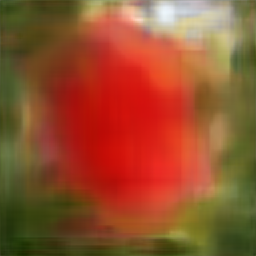

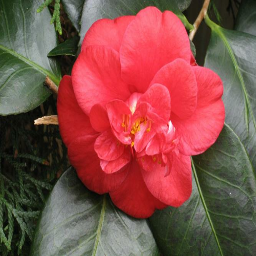

<class 'numpy.ndarray'> (32, 256, 256, 3) <class 'numpy.ndarray'> [ 94  96  81  55  69  48  63  32  27  77   1  51  72 100  77  10  16  50
 101  97  83  36  87  42  49  69  42  76  43  45  64  50]
(256, 256, 3)


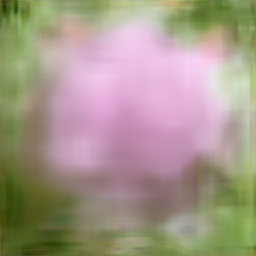

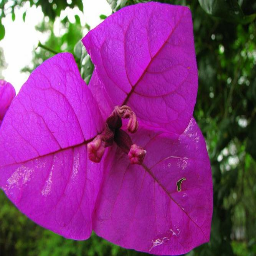

<class 'numpy.ndarray'> (32, 256, 256, 3) <class 'numpy.ndarray'> [40 76 42 63 45 94 94 51 19 46 73 70 72 93 89 10 79 31 22 42 96 23 95 39
 65 97 24 88 44 43 77 66]
(256, 256, 3)


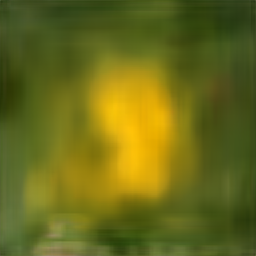

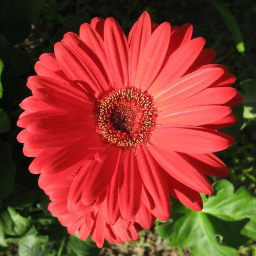

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import array_to_img
ds_train = ds_train.batch(1)
take=ds_test.take(3)
from IPython.display import display
for image, label in tfds.as_numpy(take):
  print(type(image), image.shape, type(label), label)
  figure= vae.predict(np.array([image[0]]))[0]
  print(figure.shape)
  # plt.figure(figsize=(10, 10))
  # plt.imshow(figure)
  # plt.show()
  display(array_to_img(figure))
  display(array_to_img(image[0]))

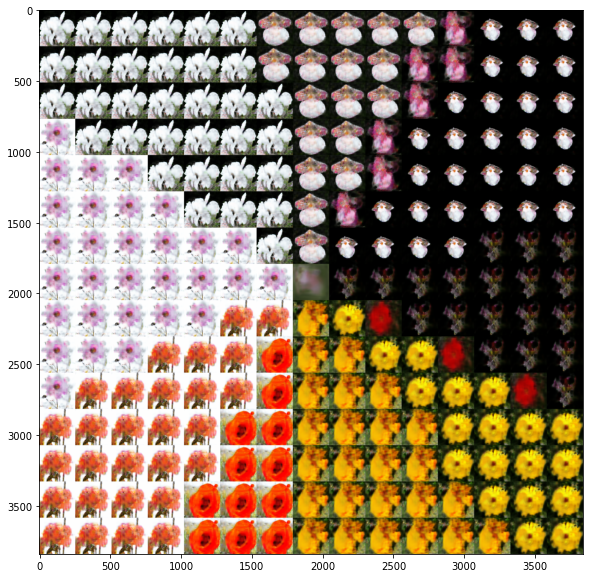

In [ ]:
import matplotlib.pyplot as plt

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = SIZE
figure = np.zeros((digit_size * n, digit_size * n,3))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
scale=1
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi*scale, yi*scale]]) #SCALING, bc batchnorm?
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size, 3)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size  ] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


In [ ]:
def sample_img(x,y):#,z,x1,x2,x3,x4,x5,x6,x7): 
      z_sample = np.array([[x, y]])#,z,x1,x2,x3,x4,x5,x6,x7]])
      #z_sample = np.random.random(size=(1,16))
      figure =  decoder.predict(z_sample)[0]
      plt.figure(figsize=(10, 10))
      plt.imshow(figure)
      plt.show()
interact(sample_img, x=(-100.0,100.0),y=(-100.0,100.0))#, z=(-10.0,10.0), x7=(-10.0,10.0),x1=(-10.0,10.0),x2=(-10.0,10.0),x3=(-10.0,10.0),x4=(-10.0,10.0),x5=(-10.0,10.0),x6=(-10.0,10.0))
# z_sample=np.array([[25, 40,0,0,0,0,0,56,0,0,0,0,0,6,0,0,0,40,0,0,0,0,0,0,0,0,70,0,50,0,100,4]])
# figure=  decoder.predict(z_sample)[0].reshape(SIZE,SIZE,3)
# plt.figure(figsize=(10, 10))
# plt.imshow(figure)
# plt.show()


interactive(children=(FloatSlider(value=0.0, description='x', min=-100.0), FloatSlider(value=0.0, description=…

<function __main__.sample_img>

# Super Res

70770688/70763455 [==============================] - 26s 0us/step
Found 500 files belonging to 1 classes.
Using 400 files for training.
Found 500 files belonging to 1 classes.
Using 100 files for validation.


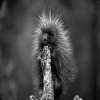

(100, 100, 1)


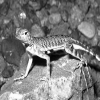

(100, 100, 1)


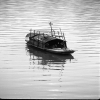

(100, 100, 1)


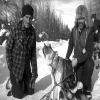

(100, 100, 1)


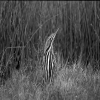

(100, 100, 1)


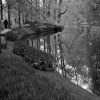

(100, 100, 1)


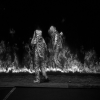

(100, 100, 1)


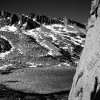

(100, 100, 1)


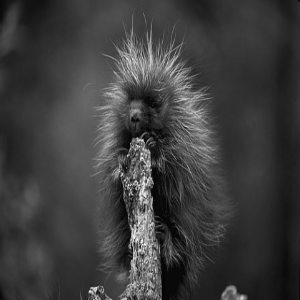

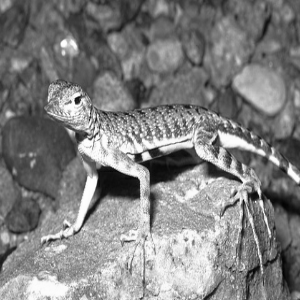

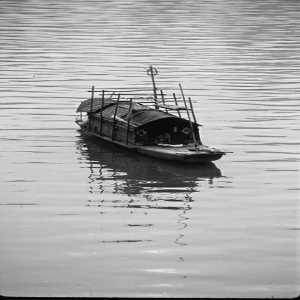

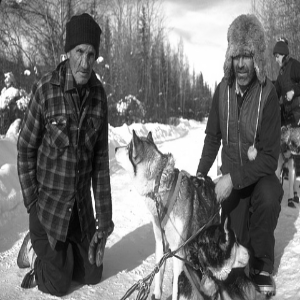

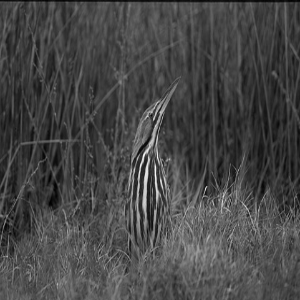

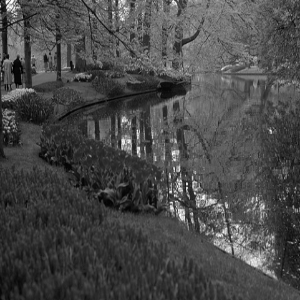

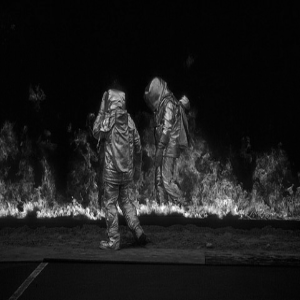

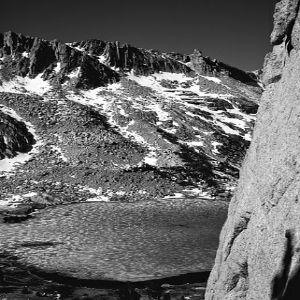

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, None, None, 64)    1664      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_26 (Conv2D)           (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, None, None, 9)     2601      
_________________________________________________________________
tf.nn.depth_to_space (TFOpLa (None, None, None, 1)     0         
Total params: 59,657
Trainable params: 59,657
Non-trainable params: 0
_________________________________________________________

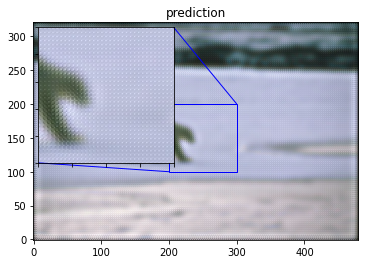

Epoch 2/100
50/50 - 2s - loss: 0.0070 - val_loss: 0.0042
Mean PSNR for epoch: 23.65
Epoch 3/100
50/50 - 2s - loss: 0.0040 - val_loss: 0.0031
Mean PSNR for epoch: 25.24
Epoch 4/100
50/50 - 2s - loss: 0.0034 - val_loss: 0.0029
Mean PSNR for epoch: 25.89
Epoch 5/100
50/50 - 2s - loss: 0.0031 - val_loss: 0.0026
Mean PSNR for epoch: 25.97
Epoch 6/100
50/50 - 2s - loss: 0.0029 - val_loss: 0.0025
Mean PSNR for epoch: 26.24
Epoch 7/100
50/50 - 2s - loss: 0.0028 - val_loss: 0.0025
Mean PSNR for epoch: 26.29
Epoch 8/100
50/50 - 2s - loss: 0.0030 - val_loss: 0.0025
Mean PSNR for epoch: 26.22
Epoch 9/100
50/50 - 2s - loss: 0.0028 - val_loss: 0.0024
Mean PSNR for epoch: 26.42
Epoch 10/100
50/50 - 2s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.27
Epoch 11/100
50/50 - 2s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.37
Epoch 12/100
50/50 - 2s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.12
Epoch 13/100
50/50 - 2s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for e

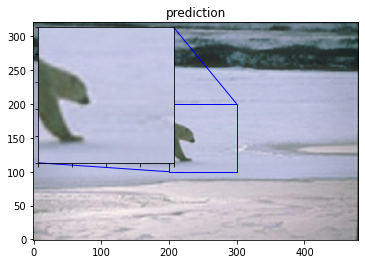

Epoch 22/100
50/50 - 2s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.27
Epoch 23/100
50/50 - 2s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.67
Epoch 24/100
50/50 - 2s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.74
Epoch 25/100
50/50 - 2s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 27.06
Epoch 26/100
50/50 - 2s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.21
Epoch 27/100
50/50 - 2s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 27.24
Epoch 28/100
50/50 - 2s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.58
Epoch 29/100
50/50 - 2s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.66
Epoch 30/100
50/50 - 2s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.47
Epoch 31/100
50/50 - 2s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.16
Epoch 32/100
50/50 - 2s - loss: 0.0027 - val_loss: 0.0023
Mean PSNR for epoch: 26.44
Epoch 33/100
50/50 - 2s - loss: 0.0026 - val_loss: 0.0023
Mean PS

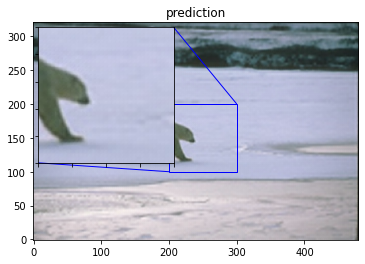

Epoch 42/100
50/50 - 2s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.62
Epoch 43/100
50/50 - 2s - loss: 0.0028 - val_loss: 0.0023
Mean PSNR for epoch: 26.86
Epoch 44/100
50/50 - 2s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.88
Epoch 45/100
50/50 - 2s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.48
Epoch 46/100
50/50 - 2s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.28
Epoch 47/100
50/50 - 2s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.57
Epoch 48/100
50/50 - 2s - loss: 0.0026 - val_loss: 0.0024
Mean PSNR for epoch: 26.03
Epoch 49/100
50/50 - 2s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.56
Epoch 50/100
50/50 - 2s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.41
Epoch 51/100
50/50 - 2s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.73
Epoch 52/100
50/50 - 2s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.39
Epoch 53/100
50/50 - 2s - loss: 0.0025 - val_loss: 0.0022
Mean PS

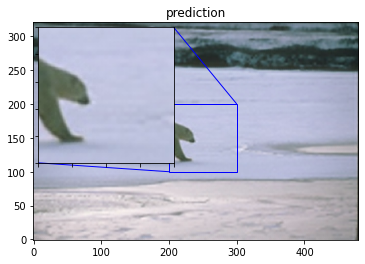

Epoch 62/100
50/50 - 2s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.29
Epoch 63/100
50/50 - 2s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.34
Epoch 64/100
50/50 - 2s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 27.35
Epoch 65/100
50/50 - 2s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.90
Epoch 66/100
50/50 - 2s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.44
Epoch 67/100
50/50 - 2s - loss: 0.0025 - val_loss: 0.0035
Mean PSNR for epoch: 24.68
Epoch 68/100
50/50 - 2s - loss: 0.0028 - val_loss: 0.0022
Mean PSNR for epoch: 26.71
Epoch 69/100
50/50 - 2s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.45
Epoch 70/100
50/50 - 2s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.74
Epoch 71/100
50/50 - 2s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.73
Epoch 72/100
50/50 - 2s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.88
Epoch 73/100
50/50 - 2s - loss: 0.0025 - val_loss: 0.0022
Mean PS

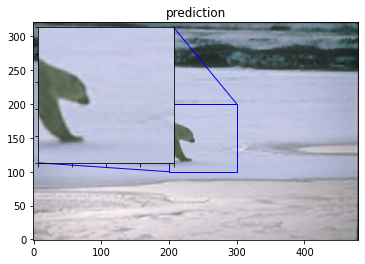

Epoch 82/100
50/50 - 2s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.67
Epoch 83/100
50/50 - 2s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.87
Epoch 84/100
50/50 - 2s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.69
Epoch 85/100
50/50 - 2s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.80
Epoch 86/100
50/50 - 2s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.19
Epoch 87/100
50/50 - 2s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.52
Epoch 88/100
50/50 - 2s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.38
Epoch 89/100
50/50 - 2s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.56
Epoch 90/100
50/50 - 2s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.39
Epoch 91/100
50/50 - 2s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.32
Epoch 92/100
50/50 - 2s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.87
Epoch 93/100
50/50 - 2s - loss: 0.0024 - val_loss: 0.0022
Mean PS

In [ ]:
import tensorflow as tf

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
data_dir = keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
root_dir = os.path.join(data_dir, "BSDS500/data")

crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)

def scaling(in_img):
    in_img= in_img/255.
    return in_img
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

dataset = os.path.join(root_dir, "images")
test_path = os.path.join(dataset, "test")

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpg")
    ]
)

#data_prep

def process_ins(input, input_size, upscale_factor):
    input=tf.image.rgb_to_yuv(input)
    last_dim_axis= len(input.shape)-1
    y,u,v= tf.split(input,3, axis=last_dim_axis)
    return tf.image.resize(y,[input_size,input_size], method='area')

def process_target(input):
    input= tf.image.rgb_to_yuv(input)
    last_dim_axis= len(input.shape)-1
    y,u,v= tf.split(input,3, axis=last_dim_axis)
    return y

train_ds= train_ds.map( lambda x: ( process_ins(x,input_size, upscale_factor), process_target(x) ) )
train_ds.prefetch(buffer_size=32)


valid_ds= valid_ds.map( lambda x: (process_ins(x,input_size, upscale_factor), process_target(x)))
valid_ds.prefetch(buffer_size=32)


for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
        print(img.shape)
    for img in batch[1]:
        display(array_to_img(img))

def upscale_model(upscale_factor=3, channels=1):
    conv_ags={"activation": "relu", "kernel_initializer":"Orthogonal", "padding": "same"}

    inputs= keras.Input(shape= (None, None, channels))
    x=tf.keras.layers.Conv2D(64,5,**conv_ags)(inputs)
    x=tf.keras.layers.Conv2D(64,3,**conv_ags)(x)
    x=tf.keras.layers.Conv2D(32,3,**conv_ags)(x)
    x=tf.keras.layers.Conv2D(channels*(upscale_factor**2),3,**conv_ags)(x)
    outputs= tf.nn.depth_to_space(x,upscale_factor) #what does this do?

    return keras.Model(inputs, outputs)
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img
epochs = 100


class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = upscale_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)


# Testing and Play


In [ ]:
import PIL

def sample_img(x,y):#,z,x1,x2,x3,x4,x5,x6,x7): 
      z_sample = np.array([[x, y]])#,z,x1,x2,x3,x4,x5,x6,x7]])
      data=np.uint8(decoder.predict(z_sample)[0].reshape(256,256,3)*255)
      img= PIL.Image.fromarray( data )
      print(data.shape)
      figure =  upscale_image(model,img)
      print(np.array(figure).shape)
      plt.figure(figsize=(10, 10))
      plt.imshow(figure)
      plt.show()
interact(sample_img, x=(-100.0,100.0),y=(-100.0,100.0))

interactive(children=(FloatSlider(value=0.0, description='x', min=-100.0), FloatSlider(value=0.0, description=…

<function __main__.sample_img>